In [1]:
import yfinance as yf
from dataclasses import dataclass
from scipy.stats import kstest
import numpy as np
from scipy.stats import norm
from tabulate import tabulate
from rich import print
from matplotlib import pyplot as plt

# stocks = yf.Tickers("TSLA AAPL")
# hist = stocks.history(start="2023-01-01", end="2023-07-31")
# prices = hist["Close"]

In [2]:

@dataclass
class Stock:
    ticker: str
    prices: np.ndarray
    
    @property
    def returns(self):
        return np.diff(np.log(self.prices))
    
    def clip_prices(self, lower_bound=0, upper_bound=0.99):
        self.prices = np.clip(
            self.prices,
            np.quantile(self.prices, lower_bound),
            np.quantile(self.prices, upper_bound),
        )
        return self
    def test_log_normality(self, significance_level=0.10):
        ks_test = kstest(
            self.prices,
            "lognorm",
            args=(np.mean(self.prices), np.std(self.prices)),
        )
        if ks_test.pvalue < significance_level:
            print(
                f"The p-value is {ks_test.pvalue}. \n We **reject** the null hypothesis that the data is log-normally distributed at the {significance_level} significance level."
            )
        else:
            print(
                f"The p-value is {ks_test.pvalue}. \n  We **fail to reject** the null hypothesis that the data is log-normally distributed at the {significance_level} significance level."
            )
        return self
    
    def test_normality_of_returns(self, significance_level=0.10):
        ks_test = kstest(
            self.returns,
            'norm',
            args = (np.mean(self.returns), np.std(self.returns))
        )
        if ks_test.pvalue < significance_level:
            print(
                f"The p-value is {ks_test.pvalue}. \n We **reject** the null hypothesis that the data is normally distributed at the {significance_level} significance level."
            )
        else:
            print(
                f"The p-value is {ks_test.pvalue}. \n  We **fail to reject** the null hypothesis that the data is normally distributed at the {significance_level} significance level."
            )
        return self

    def __repr__(self) -> str:
        return f"{self.ticker} with {len(self.prices)} observations"
    

In [3]:
tesla = Stock('TSLA',prices['TSLA'].dropna().to_numpy())
apple = Stock('AAPL',prices['AAPL'].dropna().to_numpy())

### Black Scholes Model

$c = S_0 \mathcal{N}(d_1) - K e^{-rT}\mathcal{N}(d_2) $

Here:

$$d_1 = \frac{ln(\frac{S_0}{K}) + (r + \frac{\sigma^2}{2})T}{\sigma \sqrt{T}}$$

and

$d_2 = d_1 - \sigma \sqrt{T}$

where:
$S_0$ is the spot price of the underlying asset at time 0
$K$ is the strike price
$r$ is the risk free rate
$T$ is the time to maturity
$\sigma$ is the volatility of the underlying asset


In [32]:

class BlackScholes:
    def __init__ (self, stock_price, strike_price, sigma, risk_free_rate, time_to_maturity ):
        self.stock_price = stock_price
        self.strike_price = strike_price
        self.sigma = sigma
        self.risk_free_rate = risk_free_rate
        self.time_to_maturity = time_to_maturity
        self.volatility = self.sigma * np.sqrt(self.time_to_maturity) 
        self.d1 = (np.log(self.stock_price / self.strike_price) + (self.risk_free_rate - 0.5 * self.sigma ** 2) * self.time_to_maturity) / self.volatility
        self.d2 = self.d1 + self.volatility
        self.call_delta = norm.cdf(self.d2)
        self.put_delta = norm.cdf(-self.d2)
        self.gamma = norm.pdf(self.d1) / (self.stock_price * self.volatility, np.sqrt(self.time_to_maturity))
        self.vega = self.stock_price * norm.pdf(self.d1) * np.sqrt(self.time_to_maturity)
        self.theta = - (self.stock_price * norm.pdf(self.d1) * self.sigma) / (2 * np.sqrt(self.time_to_maturity)) - self.risk_free_rate * self.strike_price * np.exp(-self.risk_free_rate * self.time_to_maturity) * norm.cdf(self.d2)
        self.price_call()
        self.price_put()
        self.check_put_call_parity()
        
    
    def price_call (self):
        if hasattr(self, 'call_price'):
           return self.call_price 
        else:
            self.call_price = (self.stock_price * self.call_delta) - (self.strike_price * np.exp(-self.risk_free_rate * self.time_to_maturity) * norm.cdf(self.d1))
        return self
    
    def price_put (self):
        if hasattr(self, 'put_price'):
            return self.put_price 
        else:
            self.put_price = (self.strike_price * np.exp(-self.risk_free_rate * self.time_to_maturity) * norm.cdf(-self.d1)) - (self.stock_price * norm.cdf(-self.d2))
        return self 
            
    
    def check_put_call_parity (self):
        lhs = self.call_price - self.put_price
        rhs = self.stock_price - (self.strike_price * np.exp(-self.risk_free_rate * self.time_to_maturity))
        self.put_call_parity = np.allclose(lhs, rhs, rtol=1e-05, atol=1e-08) 
    
    def __repr__ (self):
        attributes = ['call_price','put_price','put_call_parity', 'call_delta','put_delta','d1', 'd2', 'gamma', 'vega', 'theta', 'stock_price', 'strike_price', 'sigma', 'risk_free_rate', 'time_to_maturity', 'volatility']
        round_if_float = lambda x: round(x, 2) if isinstance(x, float) else x
        attribute_info = [[attr, round_if_float(getattr(self, attr))] for attr in attributes]
        return tabulate(attribute_info, headers=["Attribute", "Value"], tablefmt="grid")
            

In [33]:
b = BlackScholes(stock_price=100, strike_price=100, time_to_maturity=3, risk_free_rate=0.05, sigma=0.2)
print(b)

c:\Users\kumar\AppData\Local\Programs\Python\Python311\Lib\site-packages\tabulate\__init__.py:108: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  or (len(row) >= 2 and row[1] == SEPARATING_LINE)


+------------------+-------------------------+
| Attribute        | Value                   |
+==================+=========================+
| call_price       | 20.92                   |
+------------------+-------------------------+
| put_price        | 7.0                     |
+------------------+-------------------------+
| put_call_parity  | True                    |
+------------------+-------------------------+
| call_delta       | 0.73                    |
+------------------+-------------------------+
| put_delta        | 0.27                    |
+------------------+-------------------------+
| d1               | 0.26                    |
+------------------+-------------------------+
| d2               | 0.61                    |
+------------------+-------------------------+
| gamma            | [0.01113428 0.22268553] |
+------------------+-------------------------+
| vega             | 66.81                   |
+------------------+-------------------------+
| theta            | -5.36                   |
+------------------+-------------------------+
| stock_price      | 100                     |
+------------------+-------------------------+
| strike_price     | 100                     |
+------------------+-------------------------+
| sigma            | 0.2                     |
+------------------+-------------------------+
| risk_free_rate   | 0.05                    |
+------------------+-------------------------+
| time_to_maturity | 3                       |
+------------------+-------------------------+
| volatility       | 0.35                    |
+------------------+-------------------------+

$$S_{T} = S_{t} e^{\left(\left(r-\frac{1}{2}\sigma^{2}\right)(T-t) +\sigma \sqrt{T-t}\,z\right)}\,,$$

In [18]:
r = 0.06
sigma = 0.3
T = 1.0
S0 = 100

Ite = 100000
M = 100

dt = T / M

S = np.zeros((M + 1, Ite))
S[0] = S0
for t in range(1, M + 1):
    S[t] = S[t - 1] * np.exp(
        (r - 0.5 * sigma**2) * dt + sigma * np.sqrt(dt) * np.random.standard_normal(Ite)
    )

In [37]:
T = 1   
t = 0
S = 100
K = 95
r = 0.06
sigma = 0.3
data = np.zeros((Ite, 2)) # Creates a matrix of zeroes of length Ite x 2
z = np.random.normal(0, 1, [1, Ite])
ST = S * np.exp((T - t) * (r - 0.5 * sigma**2) + sigma * np.sqrt(T - t) * z)
data[:, 1] = ST - K

# average = np.sum(np.amax(data, axis=1)) / float(Ite)
(np.sum(np.amax(data, axis=1)) / float(Ite)) * np.exp(-r * (T-t))


17.340303730270232

# Price Call Option

In [32]:
T = 1   
t = 0
S = 100
K = 95
r = 0.06
sigma = 0.3
data = np.zeros((Ite, 2)) # Creates a matrix of zeroes of length Ite x 2
z = np.random.normal(0, 1, [1, Ite])
ST = S * np.exp((T - t) * (r - 0.5 * sigma**2) + sigma * np.sqrt(T - t) * z)
data[:, 1] = ST - K

# average = np.sum(np.amax(data, axis=1)) / float(Ite)
(np.sum(np.amax(data, axis=1)) / float(Ite)) * np.exp(-r * (T-t))

array([[  0.        ,  49.76725027],
       [  0.        ,   4.7555717 ],
       [  0.        ,  -5.9139897 ],
       ...,
       [  0.        , 125.17064136],
       [  0.        ,  83.98277026],
       [  0.        ,  25.17431963]])

## Price put option

In [44]:
np.random.seed(2)
Ite = 3000
T = 3/12   
t = 0
S = 118.75
K = 122
r = 0.015
sigma = 0.25
data = np.zeros((Ite, 2)) # Creates a matrix of zeroes of length Ite x 2
z = np.random.normal(0, 1, [1, Ite])
ST = S * np.exp((T - t) * (r - 0.5 * sigma**2) + sigma * np.sqrt(T - t) * z)
data[:, 1] = K- ST

# average = np.sum(np.amax(data, axis=1)) / float(Ite)
(np.sum(np.amax(data, axis=1)) / float(Ite)) * np.exp(-r * (T-t))

7.586098426399119

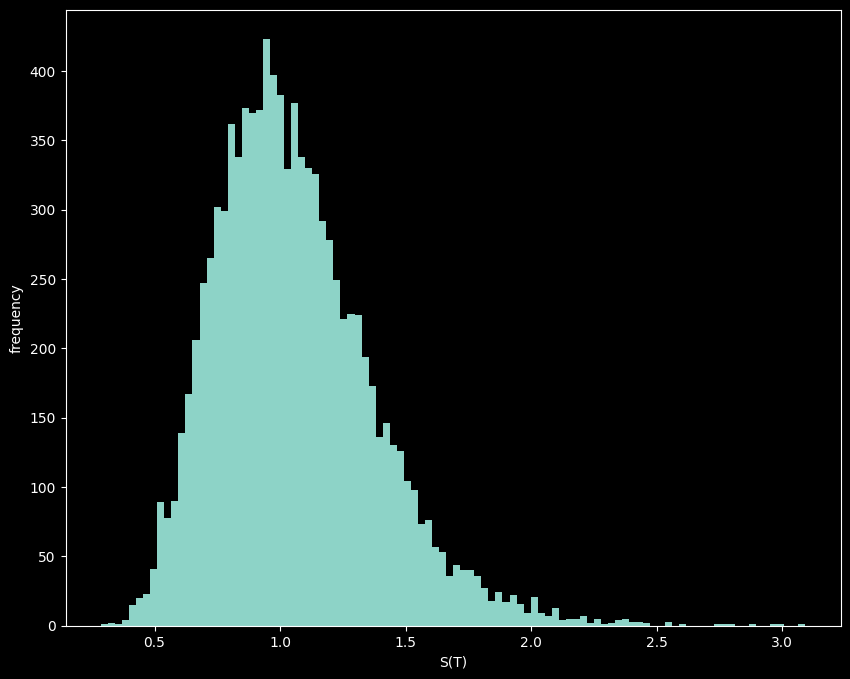

In [52]:
plt.figure(figsize=(10, 8))
plt.hist(S[97], bins=1a00)
plt.xlabel("S(T)")
plt.ylabel("frequency")
plt.show()